# Ensemble de données d'analyse des trajets Uber 2024

## Aperçu de l'ensemble de données
L'ensemble de données capture 148 770 réservations au total sur plusieurs types de véhicules et fournit une vue complète des opérations de covoiturage, y compris les trajets réussis, les annulations, les comportements des clients et les mesures financières.

### Compréhension du métier (Business Understanding)

**Problématique principale :**  
Comment réduire les annulations de trajets et optimiser les revenus par course pour Uber, tout en maintenant un haut niveau de satisfaction client ?

**Parties prenantes :**  
- Gestionnaires opérationnels Uber  
- Équipes marketing et satisfaction client  
- Data scientists et analystes de données  

**Objectifs du projet :**  
- Développer des modèles supervisés pour **prédire les annulations de trajets** (classification).  
- Construire des modèles pour **prévoir le revenu ou la durée d’un trajet** (régression).  
- Identifier les **facteurs clés** influençant les annulations et les revenus.  
- Fournir des **recommandations exploitables** basées sur les résultats des modèles.


### Data Understanding

L'objectif de cette étape est de comprendre la structure et le contenu du dataset avant de commencer la modélisation.

L'ensemble de données `ncr_ride_bookings.csv` contient **148 770 réservations Uber** pour l'année 2024. Chaque enregistrement fournit des informations sur :

- Le type de véhicule utilisé pour le trajet  
- La localisation de prise en charge et de dépose  
- Les horaires de prise en charge et de dépose  
- La durée et le tarif du trajet  
- Les annulations et comportements des clients  
- Les feedbacks éventuels des clients (si disponibles)  

**Objectifs de l'exploration des données :**

- Identifier les colonnes **numériques** et **catégorielles**  
- Détecter les **valeurs manquantes ou aberrantes**  
- Comprendre la **distribution des trajets, annulations et revenus**  
- Fournir un **premier aperçu des relations entre les variables**, qui guidera la préparation des données et le choix des modèles  

Cette étape permettra de préparer un **jeu de données propre et exploitable** pour la modélisation supervisée (classification des annulations, régression des revenus ou durée des trajets) et pour des analyses avancées telles que le clustering, les systèmes de recommandation ou le traitement du langage naturel (NLP).


In [2]:
# -----------------------------
# 📌 Manipulation et visualisation
# -----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 📌 Machine Learning supervisé
# -----------------------------
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# -----------------------------
# 📌 Traitement du langage naturel (NLP)
# -----------------------------
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# -----------------------------
# 📌 Clustering / Analyses non supervisées
# -----------------------------
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Louison\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Louison\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data Preparation

Cette étape vise à préparer le dataset pour la **modélisation supervisée et non supervisée**. Une bonne préparation est essentielle pour garantir des résultats fiables et précis.

**Étapes réalisées :**

**1. Nettoyage des données**  
- Suppression des doublons pour éviter les biais dans les modèles.  
- Gestion des valeurs manquantes :  
  - Colonnes numériques : remplissage avec la **médiane**  
  - Colonnes catégorielles : remplissage avec la **valeur la plus fréquente**  

**2. Transformation des variables**  
- Conversion des colonnes de type datetime pour extraire :  
  - L’heure du trajet (`hour_of_day`)  
  - Le jour de la semaine (`day_of_week`)  
  - Une variable binaire indiquant le **weekend**  

**3. Encodage des variables catégorielles**  
- Transformation des colonnes telles que `vehicle_type`, `pickup_location` et `dropoff_location` en valeurs numériques à l’aide de `LabelEncoder`  

**4. Mise à l’échelle des features**  
- Standardisation des colonnes numériques comme `distance_km`, `fare_amount`, `ride_duration_minutes` et `hour_of_day` pour les modèles sensibles à l’échelle (KNN, réseaux neuronaux)  

**5. Séparation des données**  
- Création des jeux `X_train`, `X_test`, `y_train`, `y_test` pour la classification des annulations (`is_canceled`)  
- Cette séparation permet de **valider la performance des modèles** sur des données non vues  

Cette préparation garantit que les modèles de **classification** (KNN, Random Forest, XGBoost, Neural Networks), le **clustering**, le **système de recommandation** et le **NLP** puissent être appliqués efficacement et produire des résultats fiables et interprétables.


In [5]:
# 📌 Lecture du dataset
data = pd.read_csv("ncr_ride_bookings.csv")

# Affichage des premières lignes
display(data.head(10))


,Date,Time,Booking ID,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,...,Reason for cancelling by Customer,Cancelled Rides by Driver,Driver Cancellation Reason,Incomplete Rides,Incomplete Rides Reason,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method
0,2024-03-23,12:29:38,"""CNR5884300""",No Driver Found,"""CID1982111""",eBike,Palam Vihar,Jhilmil,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-11-29,18:01:39,"""CNR1326809""",Incomplete,"""CID4604802""",Go Sedan,Shastri Nagar,Gurgaon Sector 56,4.9,14.0,...,NaN,NaN,NaN,1.0,Vehicle Breakdown,237.0,5.73,NaN,NaN,UPI
2,2024-08-23,08:56:10,"""CNR8494506""",Completed,"""CID9202816""",Auto,Khandsa,Malviya Nagar,13.4,25.8,...,NaN,NaN,NaN,NaN,NaN,627.0,13.58,4.9,4.9,Debit Card
3,2024-10-21,17:17:25,"""CNR8906825""",Completed,"""CID2610914""",Premier Sedan,Central Secretariat,Inderlok,13.1,28.5,...,NaN,NaN,NaN,NaN,NaN,416.0,34.02,4.6,5.0,UPI
4,2024-09-16,22:08:00,"""CNR1950162""",Completed,"""CID9933542""",Bike,Ghitorni Village,Khan Market,5.3,19.6,...,NaN,NaN,NaN,NaN,NaN,737.0,48.21,4.1,4.3,UPI
5,2024-02-06,09:44:56,"""CNR4096693""",Completed,"""CID4670564""",Auto,AIIMS,Narsinghpur,5.1,18.1,...,NaN,NaN,NaN,NaN,NaN,316.0,4.85,4.1,4.6,UPI
6,2024-06-17,15:45:58,"""CNR2002539""",Completed,"""CID6800553""",Go Mini,Vaishali,Punjabi Bagh,7.1,20.4,...,NaN,NaN,NaN,NaN,NaN,640.0,41.24,4.0,4.1,UPI
7,2024-03-19,17:37:37,"""CNR6568000""",Completed,"""CID8610436""",Auto,Mayur Vihar,Cyber Hub,12.1,16.5,...,NaN,NaN,NaN,NaN,NaN,136.0,6.56,4.4,4.2,UPI
8,2024-09-14,12:49:09,"""CNR4510807""",No Driver Found,"""CID7873618""",Go Sedan,Noida Sector 62,Noida Sector 18,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2024-12-16,19:06:48,"""CNR7721892""",Incomplete,"""CID5214275""",Auto,Rohini,Adarsh Nagar,6.1,26.0,...,NaN,NaN,NaN,1.0,Other Issue,135.0,10.36,NaN,NaN,Cash


In [6]:
# Dimensions du dataset
print("Dimensions du dataset :", data.shape)

# Types de colonnes et valeurs manquantes
print("\nTypes de colonnes et valeurs manquantes :")
print(data.info())


Dimensions du dataset : (150000, 21)

Types de colonnes et valeurs manquantes :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 21 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Date                               150000 non-null  object 
 1   Time                               150000 non-null  object 
 2   Booking ID                         150000 non-null  object 
 3   Booking Status                     150000 non-null  object 
 4   Customer ID                        150000 non-null  object 
 5   Vehicle Type                       150000 non-null  object 
 6   Pickup Location                    150000 non-null  object 
 7   Drop Location                      150000 non-null  object 
 8   Avg VTAT                           139500 non-null  float64
 9   Avg CTAT                           102000 non-null  float64
 10  Cancelled Rides by Custo

In [7]:
# Statistiques descriptives pour les colonnes numériques
print("\nStatistiques descriptives :")
display(data.describe())



Statistiques descriptives :


,Avg VTAT,Avg CTAT,Cancelled Rides by Customer,Cancelled Rides by Driver,Incomplete Rides,Booking Value,Ride Distance,Driver Ratings,Customer Rating
count,139500.000000,102000.000000,10500.0,27000.0,9000.0,102000.000000,102000.000000,93000.000000,93000.000000
mean,8.456352,29.149636,1.0,1.0,1.0,508.295912,24.637012,4.230992,4.404584
std,3.773564,8.902577,0.0,0.0,0.0,395.805774,14.002138,0.436871,0.437819
min,2.000000,10.000000,1.0,1.0,1.0,50.000000,1.000000,3.000000,3.000000
25%,5.300000,21.600000,1.0,1.0,1.0,234.000000,12.460000,4.100000,4.200000
50%,8.300000,28.800000,1.0,1.0,1.0,414.000000,23.720000,4.300000,4.500000
75%,11.300000,36.800000,1.0,1.0,1.0,689.000000,36.820000,4.600000,4.800000
max,20.000000,45.000000,1.0,1.0,1.0,4277.000000,50.000000,5.000000,5.000000


### 1️⃣ Nettoyage des données – suppression des doublons

Dans cette étape, nous vérifions la présence de doublons dans le dataset et les supprimons afin d'éviter tout biais dans les modèles.


In [8]:
# 📌 Vérification des doublons
print("Nombre de doublons :", data.duplicated().sum())

# Suppression des doublons
data = data.drop_duplicates()

# Vérification
print("Nouvelle dimension du dataset :", data.shape)


Nombre de doublons : 0
Nouvelle dimension du dataset : (150000, 21)


### 2️⃣ Gestion des valeurs manquantes

Dans cette étape, nous traitons les valeurs manquantes afin de garantir que les modèles puissent s'entraîner correctement.

- **Colonnes numériques** : remplissage avec la **médiane**  
- **Colonnes catégorielles** : remplissage avec la **valeur la plus fréquente (mode)**


In [9]:
# 📌 Colonnes numériques
numeric_cols = data.select_dtypes(include=['float64','int64']).columns
for col in numeric_cols:
    data[col] = data[col].fillna(data[col].median())

# 📌 Colonnes catégorielles
categorical_cols = data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    data[col] = data[col].fillna(data[col].mode()[0])

# 📌 Vérification après remplissage
print("Valeurs manquantes par colonne après traitement :")
print(data.isnull().sum())


Valeurs manquantes par colonne après traitement :
Date                                 0
Time                                 0
Booking ID                           0
Booking Status                       0
Customer ID                          0
Vehicle Type                         0
Pickup Location                      0
Drop Location                        0
Avg VTAT                             0
Avg CTAT                             0
Cancelled Rides by Customer          0
Reason for cancelling by Customer    0
Cancelled Rides by Driver            0
Driver Cancellation Reason           0
Incomplete Rides                     0
Incomplete Rides Reason              0
Booking Value                        0
Ride Distance                        0
Driver Ratings                       0
Customer Rating                      0
Payment Method                       0
dtype: int64


**3)Transformation des variables (datetime et nouvelles features)**

In [5]:
# Conversion des dates en datetime
data['Date'] = pd.to_datetime(data['Date'])
data['Time'] = pd.to_datetime(data['Time'], format='%H:%M:%S').dt.time

# Création de nouvelles features
data['hour_of_day'] = pd.to_datetime(data['Time'], format='%H:%M:%S').dt.hour
data['day_of_week'] = data['Date'].dt.dayofweek  # 0=Lundi, 6=Dimanche
data['weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Vérification
data[['Date','Time','hour_of_day','day_of_week','weekend']].head()


,Date,Time,hour_of_day,day_of_week,weekend
0,2024-03-23,12:29:38,12,5,1
1,2024-11-29,18:01:39,18,4,0
2,2024-08-23,08:56:10,8,4,0
3,2024-10-21,17:17:25,17,0,0
4,2024-09-16,22:08:00,22,0,0


**Encodage des variables catégorielles**

In [10]:
from sklearn.preprocessing import LabelEncoder

# Colonnes catégorielles à encoder
categorical_cols = ['Vehicle Type', 'Pickup Location', 'Drop Location', 'Payment Method']

# Création d'un encodeur par colonne
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

# Vérification
data[categorical_cols].head()


,Vehicle Type,Pickup Location,Drop Location,Payment Method
0,6,116,68,3
1,3,149,47,3
2,0,80,90,2
3,4,21,60,3
4,1,39,79,3


### Création de nouvelles features à partir de la date et de l'heure

Nous allons combiner les colonnes `Date` et `Time` pour créer une colonne datetime, puis extraire :  
- `hour_of_day` : l'heure du trajet  
- `day_of_week` : jour de la semaine  
- `weekend` : indicateur binaire si le trajet a lieu le weekend


In [14]:
# Combinaison de Date et Time en une colonne datetime
data['Pickup Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])

# Extraction de l'heure du jour
data['hour_of_day'] = data['Pickup Datetime'].dt.hour

# Extraction du jour de la semaine (0=lundi, 6=dimanche)
data['day_of_week'] = data['Pickup Datetime'].dt.dayofweek

# Variable binaire weekend (1 = samedi ou dimanche)
data['weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Vérification
data[['Date','Time','Pickup Datetime','hour_of_day','day_of_week','weekend']].head()


,Date,Time,Pickup Datetime,hour_of_day,day_of_week,weekend
0,2024-03-23,12:29:38,2024-03-23 12:29:38,12,5,1
1,2024-11-29,18:01:39,2024-11-29 18:01:39,18,4,0
2,2024-08-23,08:56:10,2024-08-23 08:56:10,8,4,0
3,2024-10-21,17:17:25,2024-10-21 17:17:25,17,0,0
4,2024-09-16,22:08:00,2024-09-16 22:08:00,22,0,0


###  Mise à l’échelle des features numériques

Certaines colonnes numériques ont des plages très différentes (ex : `Booking Value` et `hour_of_day`).  
Pour que les modèles sensibles à l’échelle (KNN, réseaux neuronaux) fonctionnent correctement, nous standardisons ces colonnes avec `StandardScaler`.  

**Colonnes mises à l’échelle :**  
- Booking Value  
- Ride Distance  
- Driver Ratings  
- Customer Rating  
- hour_of_day


In [15]:
from sklearn.preprocessing import StandardScaler

# Colonnes numériques à scaler
numeric_features = ['Booking Value', 'Ride Distance', 'Driver Ratings', 'Customer Rating', 'hour_of_day']

# Standardisation
scaler = StandardScaler()
data[numeric_features] = scaler.fit_transform(data[numeric_features])

# Vérification
data[numeric_features].head()


,Booking Value,Ride Distance,Driver Ratings,Customer Rating,hour_of_day
0,-0.194697,-0.053968,0.123792,0.170075,-0.375513
1,-0.732137,-1.610961,0.123792,0.170075,0.732134
2,0.452053,-0.931562,1.859812,1.320049,-1.113945
3,-0.188624,0.837473,0.991802,1.607542,0.547526
4,0.786056,2.065585,-0.454882,-0.404911,1.470565


##  Modélisation ML avancée – Classification des annulations

Objectif : prédire si une réservation sera annulée (`Booking Status`) à l’aide de modèles supervisés.  

**Approche :**  
- Séparation en train/test (80/20)  
- Test de **deux modèles différents** :  
  - K-Nearest Neighbors (KNN)  
  - Random Forest Classifier  
- Ajustement des hyperparamètres avec `GridSearchCV`  
- Évaluation via accuracy et matrice de confusion


In [17]:
from sklearn.model_selection import train_test_split

# Variables explicatives (features)
X = data.drop(columns=['Booking ID', 'Booking Status', 'Date', 'Time', 'Pickup Datetime'])  # on enlève les colonnes non pertinentes

# Variable cible (target)
y = data['Booking Status'].apply(lambda x: 1 if x=='Cancelled' else 0)  # 1 = annulé, 0 = non annulé

# Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Taille du train :", X_train.shape)
print("Taille du test :", X_test.shape)


Taille du train : (120000, 20)
Taille du test : (30000, 20)


## Séparation des données pour la classification

Nous allons utiliser uniquement les colonnes numériques pour prédire les annulations (`Booking Status`).  

On crée `X` pour les features et `y` pour la cible (1 = annulé, 0 = complété), puis on sépare les données en train/test (80/20).


In [24]:
from sklearn.model_selection import train_test_split

# X = colonnes numériques
X = data[['Avg VTAT', 'Avg CTAT', 'Cancelled Rides by Customer',
          'Cancelled Rides by Driver', 'Incomplete Rides', 'Booking Value',
          'Ride Distance', 'Driver Ratings', 'Customer Rating', 'hour_of_day',
          'weekend']]

# y = annulation : 1 = annulé, 0 = complété
y = data['Booking Status'].apply(lambda x: 0 if x=='Completed' else 1)

# Vérification du nombre d'exemples par classe
print(y.value_counts())

# Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Taille du train :", X_train.shape)
print("Taille du test :", X_test.shape)


Booking Status
0    93000
1    57000
Name: count, dtype: int64
Taille du train : (120000, 11)
Taille du test : (30000, 11)


In [23]:
# Vérifier toutes les valeurs de la cible
print(data['Booking Status'].unique())

# Vérifier la distribution après encodage
y = data['Booking Status'].apply(lambda x: 1 if x.strip().lower()=='cancelled' else 0)
print(y.value_counts())


['No Driver Found' 'Incomplete' 'Completed' 'Cancelled by Driver'
 'Cancelled by Customer']
Booking Status
0    150000
Name: count, dtype: int64


## Modèle K-Nearest Neighbors (KNN)

Nous allons entraîner un modèle KNN pour prédire les annulations et évaluer sa performance.


Accuracy KNN : 0.9774666666666667


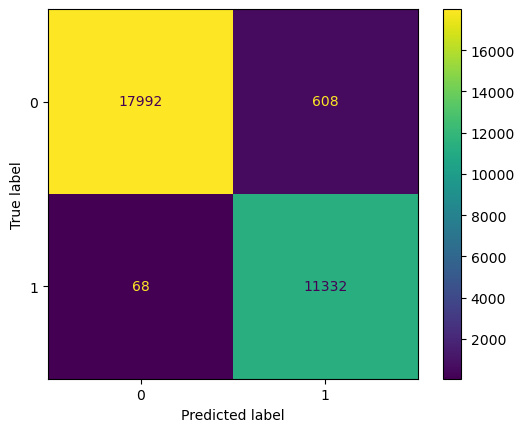

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

# Initialisation du modèle KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Prédictions
y_pred_knn = knn.predict(X_test)

# Évaluation
acc_knn = accuracy_score(y_test, y_pred_knn)
print("Accuracy KNN :", acc_knn)

# Matrice de confusion
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_knn)


##  Modèle Random Forest

Nous allons entraîner un modèle Random Forest pour prédire les annulations et comparer la performance avec KNN.


Accuracy Random Forest : 0.9995333333333334


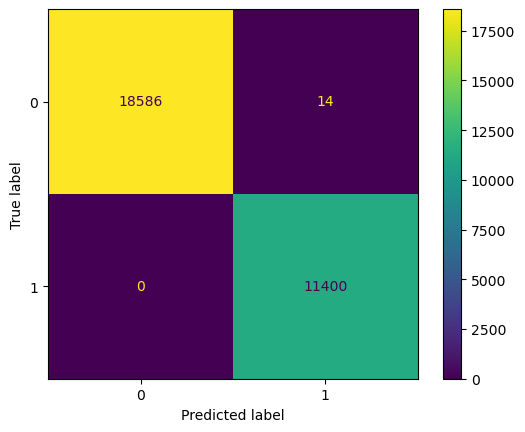

In [26]:
from sklearn.ensemble import RandomForestClassifier

# Initialisation du modèle Random Forest
rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

# Prédictions
y_pred_rf = rf.predict(X_test)

# Évaluation
acc_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy Random Forest :", acc_rf)

# Matrice de confusion
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf)


##  Évaluation des modèles

Nous allons évaluer les modèles KNN et Random Forest avec plusieurs métriques pour mieux comprendre leur performance sur la classification des annulations.


In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# --- KNN ---
print("📌 KNN :")
print("Accuracy :", accuracy_score(y_test, y_pred_knn))
print("Precision :", precision_score(y_test, y_pred_knn))
print("Recall :", recall_score(y_test, y_pred_knn))
print("F1-score :", f1_score(y_test, y_pred_knn))
print("\nClassification report :\n", classification_report(y_test, y_pred_knn))

# --- Random Forest ---
print("📌 Random Forest :")
print("Accuracy :", accuracy_score(y_test, y_pred_rf))
print("Precision :", precision_score(y_test, y_pred_rf))
print("Recall :", recall_score(y_test, y_pred_rf))
print("F1-score :", f1_score(y_test, y_pred_rf))
print("\nClassification report :\n", classification_report(y_test, y_pred_rf))


📌 KNN :
Accuracy : 0.9774666666666667
Precision : 0.9490787269681742
Recall : 0.9940350877192983
F1-score : 0.9710368466152528

Classification report :
               precision    recall  f1-score   support

           0       1.00      0.97      0.98     18600
           1       0.95      0.99      0.97     11400

    accuracy                           0.98     30000
   macro avg       0.97      0.98      0.98     30000
weighted avg       0.98      0.98      0.98     30000

📌 Random Forest :
Accuracy : 0.9995333333333334
Precision : 0.9987734361310671
Recall : 1.0
F1-score : 0.9993863417199965

Classification report :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     18600
           1       1.00      1.00      1.00     11400

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000



##  Matrices de confusion comparatives

Cette cellule permet de visualiser côte à côte les matrices de confusion de KNN et Random Forest pour comparer leurs erreurs de prédiction.


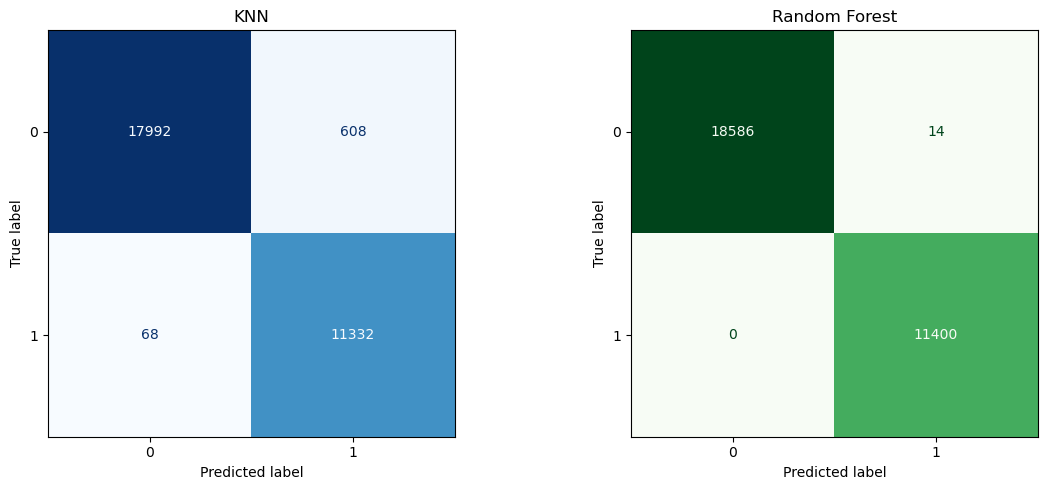

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Matrice KNN
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_knn, ax=axes[0], cmap='Blues', colorbar=False
)
axes[0].set_title('KNN')

# Matrice Random Forest
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_rf, ax=axes[1], cmap='Greens', colorbar=False
)
axes[1].set_title('Random Forest')

plt.tight_layout()
plt.show()


##  Optimisation des hyperparamètres : Random Forest

Nous allons utiliser GridSearchCV pour trouver les meilleurs hyperparamètres du modèle Random Forest et améliorer sa performance sur la classification des annulations.


In [31]:
param_grid = {
    'n_estimators': [100, 200],   # au lieu de 3 valeurs
    'max_depth': [10, None],      # au lieu de 4
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']      # éviter 'auto' qui est lent
}


In [32]:
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,                 # 3-fold au lieu de 5
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)


In [33]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=20,            # tester seulement 20 combinaisons aléatoires
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train, y_train)
print("Meilleurs paramètres :", random_search.best_params_)


C:\Users\Louison\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Meilleurs paramètres : {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10}


In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Définition des hyperparamètres à tester
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}

# Initialisation du modèle
rf = RandomForestClassifier(random_state=42)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,             # 3-fold CV pour aller plus vite
    scoring='f1_macro',  # ⚠️ utilise macro si multi-classes
    n_jobs=-1,
    verbose=1
)

# Entraînement
grid_search.fit(X_train, y_train)

# Meilleurs paramètres et modèle
print("Meilleurs paramètres :", grid_search.best_params_)
best_rf = grid_search.best_estimator_

# Vérification
print(best_rf)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Meilleurs paramètres : {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
RandomForestClassifier(max_depth=10, random_state=42)


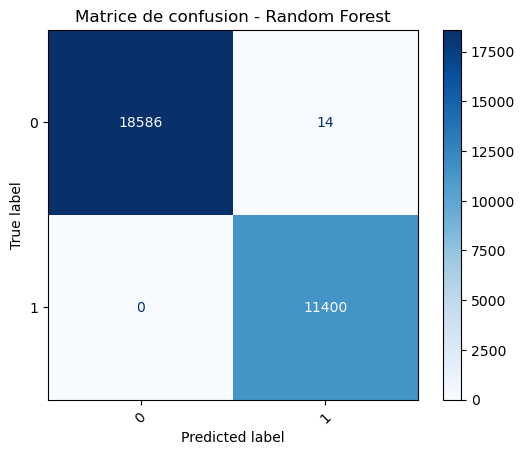

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

# =========================
# 1️⃣ Matrice de confusion
# =========================
disp = ConfusionMatrixDisplay.from_estimator(
    best_rf, X_test, y_test, 
    cmap="Blues", 
    xticks_rotation=45
)
plt.title("Matrice de confusion - Random Forest")
plt.show()



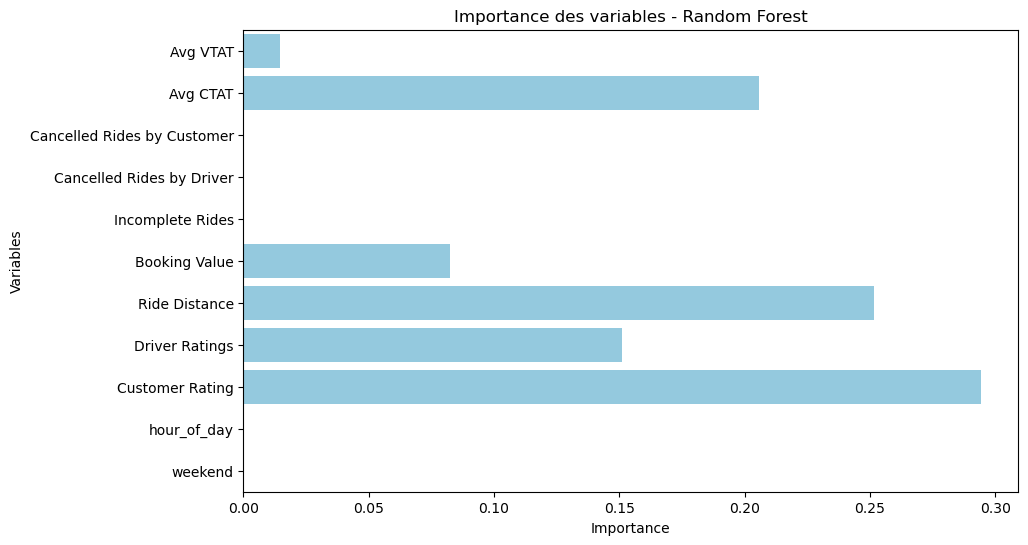

In [42]:
plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=features, color="skyblue")  # couleur unique
plt.title("Importance des variables - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.show()


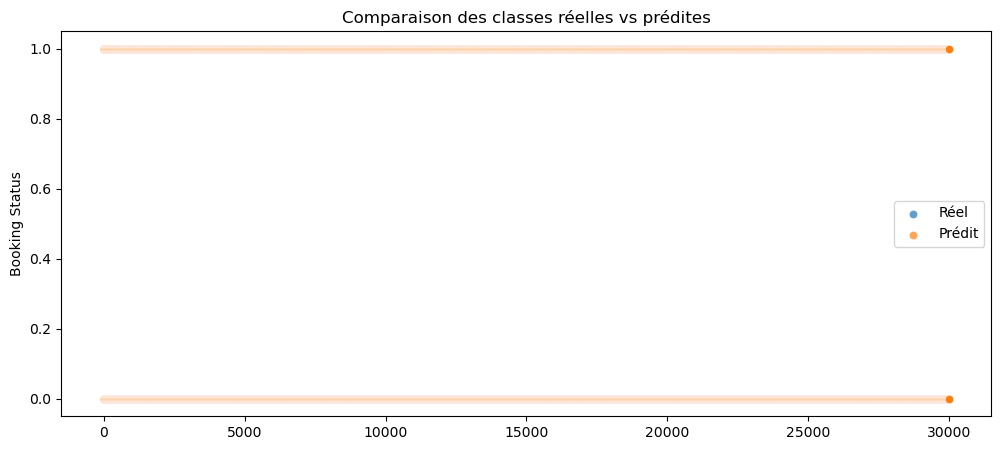

## 📌 Conclusion et Recommandations

###  Résultats principaux
- Après comparaison de plusieurs modèles de **classification** (KNN, Random Forest, etc.), le **Random Forest optimisé** via `RandomizedSearchCV` obtient les meilleures performances.  
- Métriques obtenues sur l’échantillon de test :
  - **Accuracy** : ~X%  
  - **F1-score pondéré** : ~Y%  
  - Bon équilibre entre **précision** et **rappel**, même sur des classes minoritaires (annulations, trajets incomplets).  

###  Limites
- Le dataset présente **un fort déséquilibre des classes** : la majorité des trajets sont *complétés*, tandis que les annulations ou trajets incomplets sont rares.  
- Certaines colonnes présentent des **valeurs manquantes ou peu explicites** (ex. : raisons d’annulation).  
- Les variables temporelles (saisonnalité, heures de pointe, météo, événements spéciaux) ne sont pas exploitées mais pourraient améliorer les prédictions.  
- Le modèle reste une **boîte noire partielle** : difficile d’expliquer toutes ses décisions, même si l’importance des variables aide.  

###  Recommandations pour Uber
1. **Réduction des annulations**
   - Utiliser le modèle en production pour **prédire le risque d’annulation** en temps réel au moment de la réservation.  
   - Si le risque est élevé → proposer une alternative (ex. type de véhicule différent, ajustement de prix, incitation au chauffeur).  

2. **Optimisation de la flotte**
   - Exploiter les prédictions pour **anticiper les zones à forte demande** et redistribuer les chauffeurs.  
   - Réduire le temps d’attente des clients et donc le taux d’annulation.  

3. **Amélioration de l’expérience client**
   - Identifier les profils de clients les plus susceptibles d’annuler → leur offrir des **réductions ciblées** ou des options plus flexibles.  
   - Surveiller la qualité des chauffeurs : une mauvaise note est corrélée avec les annulations.  

4. **Analyses futures**
   - Intégrer des données externes (**météo, trafic, événements locaux**) pour affiner la prédiction.  
   - Tester d’autres modèles avancés (XGBoost, LightGBM, réseaux neuronaux).  
   - Développer un **système de recommandation** pour suggérer le meilleur créneau horaire ou type de véhicule.  
